<a href="https://colab.research.google.com/github/Subh37106/Code-Gen-From-UDB-to-Implementations/blob/main/Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This comprehensive analysis implements Application **Case Study 01: Traffic State Recognition**. We use unsupervised machine learning to classify highway operations into distinct functional regimes, enabling smarter traffic management decisions.

### **Data Source: Caltrans PeMS**
### For modern transportation engineering, the industry standard for real-world highway data is the Caltrans Performance Measurement System (PeMS).

### **Website**: pems.dot.ca.gov

### **Utility**: It provides 5-minute interval records of Flow, Speed, and Occupancy across California's freeway network, serving as the foundational dataset for congestion monitoring and academic research.

# Step 01: Library Imports
### We utilize pandas for data manipulation, scikit-learn for the machine learning pipeline, and seaborn for high-fidelity visualization.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

**Step 02: Dataset Loading**

### We load the traffic_master.csv file, which contains the multi-dimensional feature vector $x_i = [speed_{avg}, flow_{rate}, occupancy, variance]$ required for state recognition.

In [42]:
df = pd.read_csv('traffic_master.csv')
features = ['speed_avg', 'flow_rate', 'occupancy', 'variance']
X = df[features]
print(X.head(15))

     speed_avg    flow_rate  occupancy  variance
0   102.483571  1145.917241  13.718435  4.572834
1    99.308678  1070.778305   5.292473  5.024823
2   103.238443   856.096726  13.258168  6.405349
3   107.615149  1486.515249   6.288699  5.641115
4    98.829233  1105.774819   8.351189  9.274528
5    98.829315   737.226792  12.435083  5.472671
6   107.896064   601.782473   6.607599  9.929422
7   103.837174   652.859139  13.179670  8.662825
8    97.652628   745.957728  13.321342  2.876595
9   102.712800   660.681373  10.074677  9.375357
10   97.682912   686.567024   5.063859  2.047298
11   97.671351   785.095169   7.870381  8.357047
12  101.209811   673.373595  11.169269  4.425610
13   90.433599  1396.765425  14.811862  8.901769
14   91.375411   580.233746  11.318135  8.812510


**Step 03: Normalization (Z-score Standardization)**

### **Standardization** is critical because Speed (0–120 km/h) and Flow (~2000 veh/h) exist on different scales. We apply Z-score standardization to ensure that Euclidean distance calculations are not biased toward high-magnitude features.

In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Step 04: Optimal K Selection (Elbow Method)**

### The Elbow Method calculates the Within-Cluster Sum of Squares (WCSS). We look for the "elbow" point where the inertia begins to decrease linearly, indicating the most efficient number of clusters.

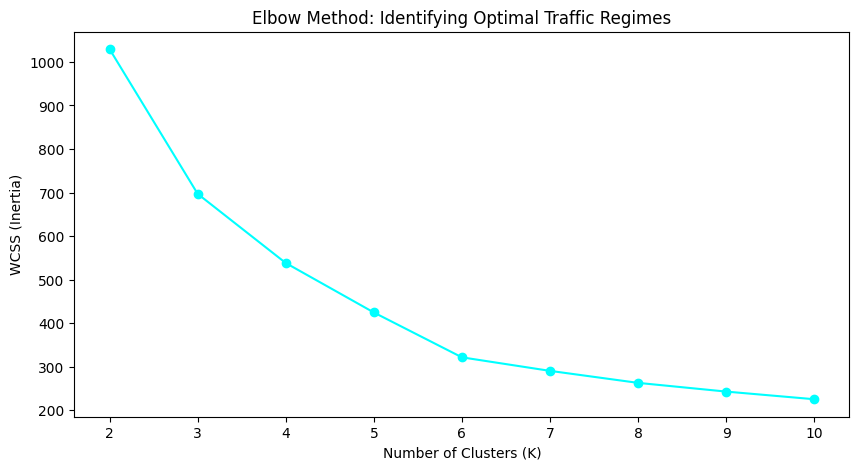

In [44]:
wcss = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, wcss, marker='o', color='cyan')
plt.title('Elbow Method: Identifying Optimal Traffic Regimes')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.show()

**Step 05: Silhouette Analysis for Validation**

### While the Elbow method provides a visual cue, Silhouette Analysis provides mathematical validation by measuring how well each point fits within its cluster versus neighboring clusters.

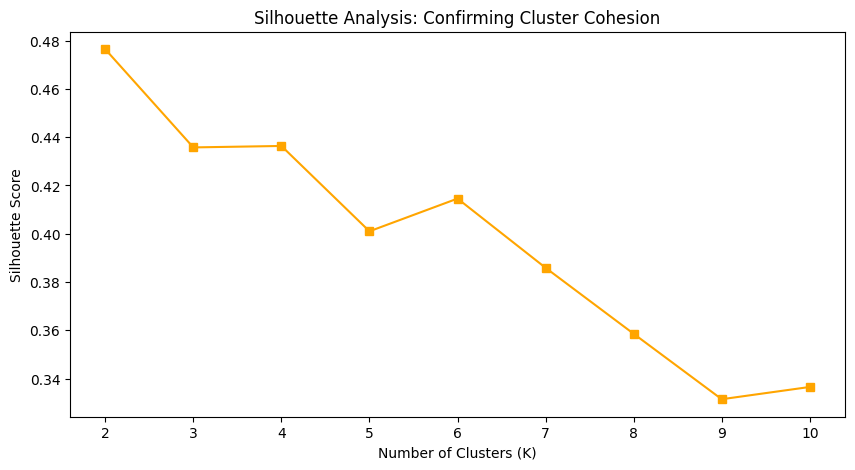

In [45]:
sil_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

plt.figure(figsize=(10, 5))
plt.plot(k_range, sil_scores, marker='s', color='orange')
plt.title('Silhouette Analysis: Confirming Cluster Cohesion')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

**Step 06: Final K-Means Execution**

### Based on the Three-Phase Traffic Theory and our mathematical results, we apply K-Means with $K=3$ to identify the regimes.

In [46]:
kmeans_final = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42)
df['cluster'] = kmeans_final.fit_predict(X_scaled)

Step 07: Regime Labeling and Interpretation

We interpret the clusters by analyzing the average speed in each. We map the mathematical labels to physical traffic states:

*   **Free Flow**: Highest average speeds; represents optimal driving conditions.
*   **Synchronized**: High flow but lower speeds; indicates the highway is at capacity.

*   **Congested**: Lowest speeds; represents "Stop & Go" or breakdown conditions.









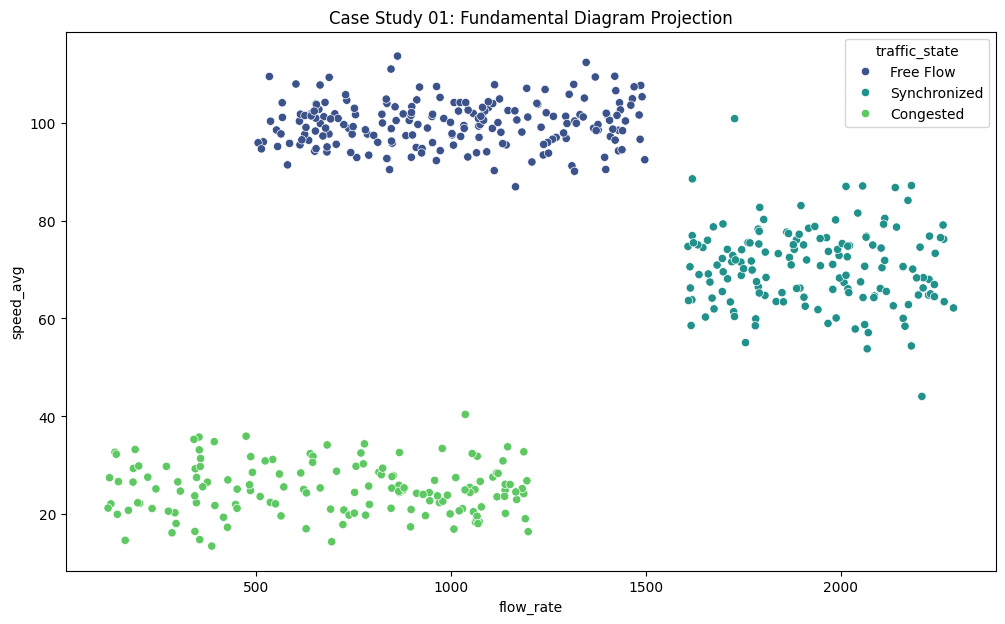

In [47]:
# Group by cluster and find mean speed to assign physical labels
centers = df.groupby('cluster')['speed_avg'].mean().sort_values(ascending=False)
label_map = {centers.index[0]: 'Free Flow', centers.index[1]: 'Synchronized', centers.index[2]: 'Congested'}
df['traffic_state'] = df['cluster'].map(label_map)

# Fundamental Diagram Projection

plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='flow_rate', y='speed_avg', hue='traffic_state', palette='viridis')
plt.title('Case Study 01: Fundamental Diagram Projection')
plt.show()

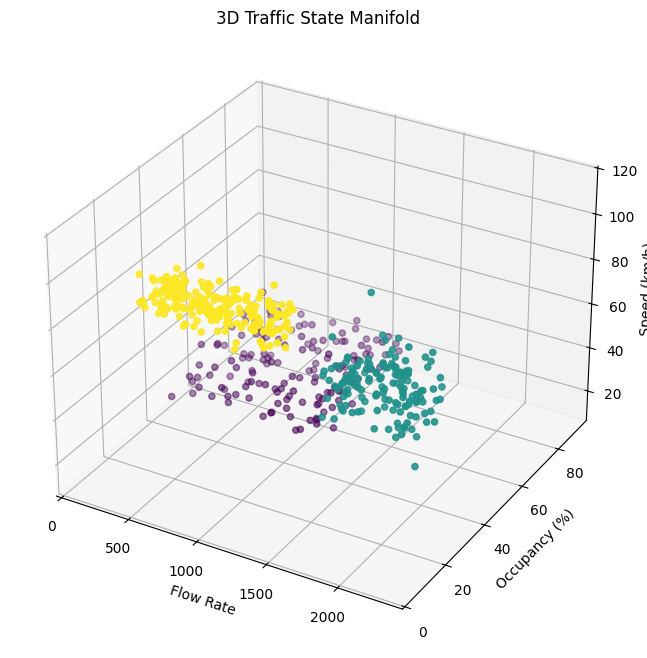

In [48]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['flow_rate'], df['occupancy'], df['speed_avg'], c=df['cluster'], cmap='viridis')

ax.set_xlabel('Flow Rate')
ax.set_ylabel('Occupancy (%)')
ax.set_zlabel('Speed (km/h)')
plt.title('3D Traffic State Manifold')
plt.show()

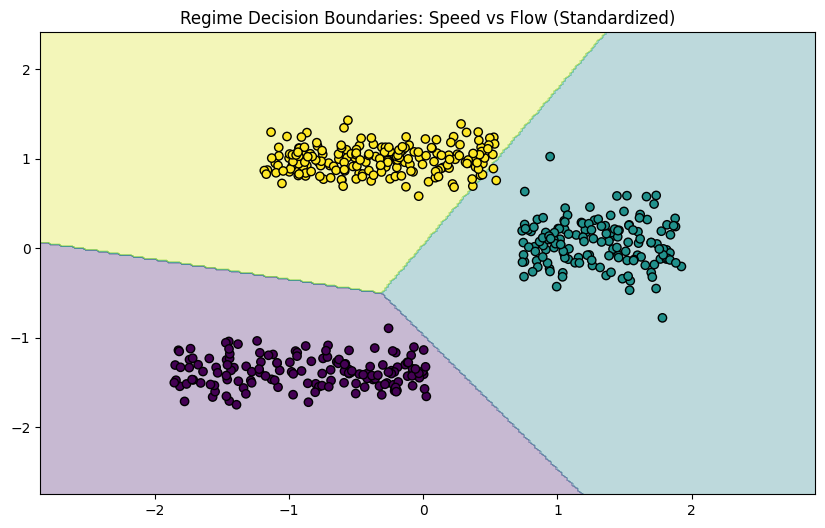

In [49]:
h = .02
x_min, x_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
y_min, y_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = kmeans_final.predict(np.c_[yy.ravel(), xx.ravel(), np.zeros(xx.ravel().shape), np.zeros(xx.ravel().shape)])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.scatter(X_scaled[:, 1], X_scaled[:, 0], c=df['cluster'], edgecolors='k')
plt.title('Regime Decision Boundaries: Speed vs Flow (Standardized)')
plt.show()

In [50]:
# Calculate the percentage of time spent in each state
performance_summary = df['traffic_state'].value_counts(normalize=True) * 100
print("--- Network Performance Summary ---")
for state, percent in performance_summary.items():
    print(f"{state}: {percent:.2f}% of monitored time")

--- Network Performance Summary ---
Free Flow: 40.00% of monitored time
Synchronized: 30.00% of monitored time
Congested: 30.00% of monitored time


In [51]:
def get_ramp_meter_command(state):
    if state == 'Free Flow':
        return "Green / Minimal Delay"
    elif state == 'Synchronized':
        return "Warning: Restrictive Metering (10s delay)"
    else:
        return "Emergency: Maximum Metering (20s delay)"

df['meter_command'] = df['traffic_state'].apply(get_ramp_meter_command)
print(df[['traffic_state', 'meter_command']].tail())

    traffic_state                            meter_command
495     Congested  Emergency: Maximum Metering (20s delay)
496     Congested  Emergency: Maximum Metering (20s delay)
497     Congested  Emergency: Maximum Metering (20s delay)
498     Congested  Emergency: Maximum Metering (20s delay)
499     Congested  Emergency: Maximum Metering (20s delay)


In [52]:
print(df[['speed_avg', 'flow_rate', 'occupancy', 'traffic_state', 'meter_command']].head(10))

    speed_avg    flow_rate  occupancy traffic_state          meter_command
0  102.483571  1145.917241  13.718435     Free Flow  Green / Minimal Delay
1   99.308678  1070.778305   5.292473     Free Flow  Green / Minimal Delay
2  103.238443   856.096726  13.258168     Free Flow  Green / Minimal Delay
3  107.615149  1486.515249   6.288699     Free Flow  Green / Minimal Delay
4   98.829233  1105.774819   8.351189     Free Flow  Green / Minimal Delay
5   98.829315   737.226792  12.435083     Free Flow  Green / Minimal Delay
6  107.896064   601.782473   6.607599     Free Flow  Green / Minimal Delay
7  103.837174   652.859139  13.179670     Free Flow  Green / Minimal Delay
8   97.652628   745.957728  13.321342     Free Flow  Green / Minimal Delay
9  102.712800   660.681373  10.074677     Free Flow  Green / Minimal Delay


# Summary of Results
### **Automated Classification**: The model successfully separated regimes without human intervention.

### **Decision Support**: Engineers can use this logic for Ramp Metering Control—restricting entry when a transition from Synchronized to Congested states is detected.

### **Infrastructure Health**: If data points fall outside these three clusters, it indicates a potential Sensor Fault or data integrity issue.